In [1]:
from toxic.model import get_model
from toxic.nltk_utils import tokenize_sentences
from toxic.train_utils import train_folds
from toxic.embedding_utils import read_embedding_list, clear_embedding_list, convert_tokens_to_ids

import argparse
import numpy as np
import os
import pandas as pd

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns


Using TensorFlow backend.


In [2]:
UNKNOWN_WORD = "_UNK_"
END_WORD = "_END_"
NAN_WORD = "_NAN_"

CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

PROBABILITIES_NORMALIZE_COEFFICIENT = 1.4

In [3]:
train_file_path = "/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/data/WikiToxicity/KaggleToxicDataset/train.csv"
test_file_path = "/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/data/WikiToxicity/KaggleToxicDataset/test.csv"
embedding_path = "/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/model/crawl/crawl-300d-2M.vec"
print("Loading data...")
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

list_sentences_train = train_data["comment_text"].fillna(NAN_WORD).values
list_sentences_test = test_data["comment_text"].fillna(NAN_WORD).values
y_train = train_data[CLASSES].values

Loading data...


In [4]:
#marking comments without any tags as "clean"
rowsums=train_data.iloc[:,2:8].sum(axis=1)
train_data['clean']=(rowsums==0)
#count number of clean entries
train_data['clean'].sum()
print("Total comments = ",len(train_data))
print("Total clean comments = ",train_data['clean'].sum())
print("Total tags =",rowsums.sum())


Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


In [6]:
from langdetect import detect
def detect_language(row):
    try:
        return detect(row)
    except:
        return "NA"

In [7]:
train_data['language'] = train_data['comment_text'].apply(detect_language)

In [8]:
test_data['language'] = test_data['comment_text'].apply(detect_language)

In [9]:
print(len(train_data))
train_data_non_english= train_data[train_data['language']!='en']
print(len(train_data_non_english))

159571
4330


In [12]:
print(len(test_data))
test_data_non_english= test_data[test_data['language']!='en']
print(len(test_data_non_english))

153164
10319


In [16]:
test_data_non_english.to_csv("test_data_non_english.csv")

/Users/sdivakarla/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


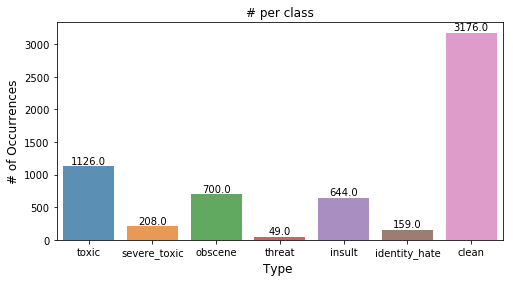

In [11]:
x=train_data_non_english.iloc[:,2:9].sum()

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [5]:
print("Tokenizing sentences in train set...")
tokenized_sentences_train, words_dict = tokenize_sentences(list_sentences_train, {})

print("Tokenizing sentences in test set...")
tokenized_sentences_test, words_dict = tokenize_sentences(list_sentences_test, words_dict)

  0%|          | 112/159571 [00:00<02:22, 1119.05it/s]

Tokenizing sentences in train set...


  0%|          | 146/153164 [00:00<01:46, 1437.55it/s]

Tokenizing sentences in test set...


100%|██████████| 153164/153164 [01:42<00:00, 1501.01it/s]


In [6]:
print(embedding_path)
words_dict[UNKNOWN_WORD] = len(words_dict)

print("Loading embeddings...")
embedding_list, embedding_word_dict = read_embedding_list(file_path=embedding_path)
embedding_size = len(embedding_list[0])

/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/model/crawl/crawl-300d-2M.vec
Loading embeddings...


100%|██████████| 1999999/1999999 [04:04<00:00, 8182.93it/s]


In [7]:
print("Preparing data...")
embedding_list, embedding_word_dict = clear_embedding_list(embedding_list, embedding_word_dict, words_dict)

embedding_word_dict[UNKNOWN_WORD] = len(embedding_word_dict)
embedding_list.append([0.] * embedding_size)
embedding_word_dict[END_WORD] = len(embedding_word_dict)
embedding_list.append([-1.] * embedding_size)

embedding_matrix = np.array(embedding_list)

Preparing data...


In [9]:
print(embedding_matrix.shape)

(170075, 300)


In [9]:
sentences_length = 500
result_path = "toxic_results"
batch_size = 256
sentences_length = 500
recurrent_units=64
dropout_rate = 0.3
dense_size=32
fold_count=10

id_to_word = dict((id, word) for word, id in words_dict.items())
train_list_of_token_ids = convert_tokens_to_ids(tokenized_sentences_train,id_to_word,
                                                embedding_word_dict,sentences_length)
test_list_of_token_ids = convert_tokens_to_ids(tokenized_sentences_test,id_to_word,
                                               embedding_word_dict,sentences_length)
X_train = np.array(train_list_of_token_ids)
X_test = np.array(test_list_of_token_ids)

In [10]:
get_model_func = lambda: get_model(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

In [24]:
from keras.layers import Dense, Embedding, Input, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, Reshape
from keras.layers import Bidirectional, Dropout, CuDNNGRU, GRU
from keras.models import Model
from keras.optimizers import RMSprop

In [32]:
input_layer = Input(shape=(sentences_length,))
embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                weights=[embedding_matrix], trainable=False)(input_layer)
x = Bidirectional(GRU(recurrent_units, return_sequences=True))(embedding_layer)
x = Dropout(dropout_rate)(x)
x = Bidirectional(GRU(recurrent_units, return_sequences=True))(x)
x_max = GlobalMaxPool1D()(x)
x_avg = GlobalAveragePooling1D()(x)
x = concatenate([x_max, x_avg])
#x = Dense(dense_size, activation="relu")(x)
output_layer = Dense(6, activation="sigmoid")(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy',optimizer=RMSprop(clipvalue=1, clipnorm=1), metrics=['accuracy'])

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 500, 300)     51022500    input_14[0][0]                   
__________________________________________________________________________________________________
bidirectional_27 (Bidirectional (None, 500, 128)     140160      embedding_14[0][0]               
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 500, 128)     0           bidirectional_27[0][0]           
__________________________________________________________________________________________________
bidirectio

In [ ]:
print("Starting to train models...")
models = train_folds(X_train, y_train, fold_count, batch_size, get_model_func)

Starting to train models...
Epoch 1/1
143614/143614 [==============================] - 3288s 23ms/step - loss: 0.0648 - acc: 0.9770
Epoch 0 loss 0.04540272414923855 best_loss -1
Epoch 1/1
106752/143614 [=====================>........] - ETA: 15:03 - loss: 0.0445 - acc: 0.9830

In [ ]:
result_path = toxic_results
if not os.path.exists(result_path):
        os.mkdir(result_path)

In [ ]:
print("Predicting results...")
test_predicts_list = []
for fold_id, model in enumerate(models):
    model_path = os.path.join(args.result_path, "model{0}_weights.npy".format(fold_id))
    np.save(model_path, model.get_weights())
    test_predicts_path = os.path.join(args.result_path, "test_predicts{0}.npy".format(fold_id))
    test_predicts = model.predict(X_test, batch_size=args.batch_size)
    test_predicts_list.append(test_predicts)
    np.save(test_predicts_path, test_predicts)

In [ ]:
test_predicts = np.ones(test_predicts_list[0].shape)
for fold_predict in test_predicts_list:
    test_predicts *= fold_predict
    test_predicts **= (1. / len(test_predicts_list))
    test_predicts **= PROBABILITIES_NORMALIZE_COEFFICIENT
    
    test_ids = test_data["id"].values
    test_ids = test_ids.reshape((len(test_ids), 1))

    test_predicts = pd.DataFrame(data=test_predicts, columns=CLASSES)
    test_predicts["id"] = test_ids
    test_predicts = test_predicts[["id"] + CLASSES]
    submit_path = os.path.join(args.result_path, "submit")
    test_predicts.to_csv(submit_path, index=False)